# Este notebook ilustra como o campo gravitacional se altera em função da topografia

In [1]:
#source1: https://neuronvisio.readthedocs.org/en/latest/gettingstarted.html#troubleshooting
#source2: http://ipython.org/ipython-doc/dev/interactive/reference.html#pyqt-and-pyside

import sip
sip.setapi('QString', 2)
sip.setapi('QVariant', 2)

In [2]:
%matplotlib inline
import numpy as np
from IPython.display import Image
from fatiando.vis import mpl, myv
from fatiando import gridder, mesher, gravmag, utils
from fatiando.gravmag import prism
from fatiando.constants import G, SI2MGAL

### Este notebook se utiliza dos conceitos abordados na aula [Cuboide](http://nbviewer.ipython.org/github/birocoles/Disciplina-metodos-potenciais/blob/master/Aulas/Cuboide_Normal/Cuboide.ipynb)

## Modelo *cubo normal* (CN)

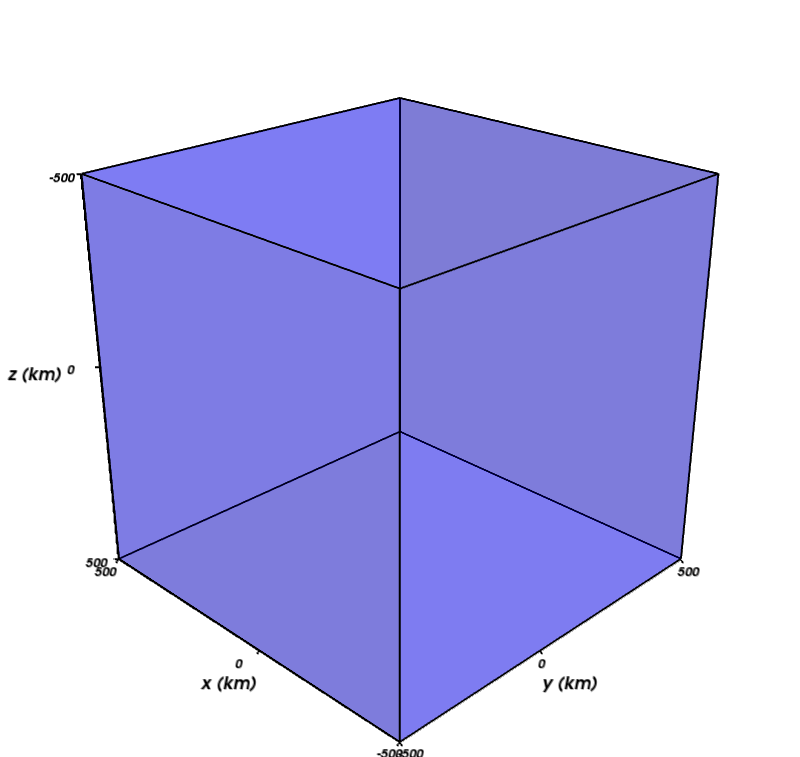

In [3]:
L = 1000000

#modelo 3D
z0 = -0.5*L
rhon = 1000
CN = [mesher.Prism(-0.5*L, 0.5*L, -0.5*L, 0.5*L, z0, z0+L, props={'density': rhon})]

MCN = 1000.0*L**3

#modelo 2D
CN2D = [mesher.Polygon([[ 0.5*L, -0.5*L], 
                        [ 0.5*L,  0.5*L], 
                        [-0.5*L,  0.5*L], 
                        [-0.5*L, -0.5*L]])]

bounds = [-0.5*L, 0.5*L, -0.5*L, 0.5*L, -0.5*L, 0.5*L] # Limites da região de visualização 3D

myv.figure(size=(800,800))
myv.prisms(CN, prop='density', opacity = 0.3)
ax = myv.axes(myv.outline(bounds), ranges=[b*0.001 for b in bounds], nlabels=3, fmt='%.0f')
ax.axes.x_label, ax.axes.y_label, ax.axes.z_label = 'x (km)', 'y (km)', 'z (km)'
ax.axes.font_factor = 1.0
myv.savefig('CN.png')
myv.show()
Image(filename='CN.png')

In [4]:
lambida = 0.1*L
area = [-lambida, lambida, 
        -lambida, lambida]
shape = (51,51)
dxp = (area[3]-area[2])/(shape[1]-1)
dyp = (area[1]-area[0])/(shape[0]-1)

xp, yp, zp = gridder.regular(area, shape, z = z0-7000)
perfil = (xp == 0.0)

## Modelo *cubo com topografia* (CT)

### Construção da topografia

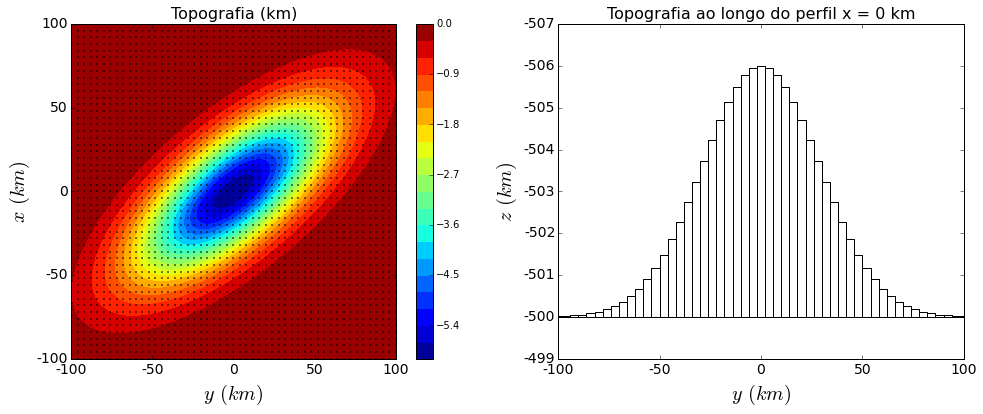

In [5]:
rhot = rhon # densidade da topografia

topo = -6000*utils.gaussian2d(xp, yp, 
                              sigma_x = 30000, sigma_y = 100000, 
                              x0 = 0.0, y0 = 0.0,
                              angle=-45)

zp_sup = topo - 1.0 + z0

TT = []
auxx = 0.5*dxp
auxy = 0.5*dyp
for i, t in enumerate(topo):
    TT.append(mesher.Prism(xp[i]-auxx, xp[i]+dxp-auxx, 
                           yp[i]-auxy, yp[i]+dyp-auxy,
                           z0+t, z0, props={'density': rhot}))
    
TT2D = []

for i, t in enumerate(topo[perfil]):
    TT2D.append(mesher.Polygon([[yp[perfil][i]-auxy, z0], 
                                [yp[perfil][i]+dyp-auxy, z0], 
                                [yp[perfil][i]+dyp-auxy, z0+t], 
                                [yp[perfil][i]-auxy, z0+t]]))
    
mpl.close('all')
mpl.figure(figsize=(16,6))
mpl.subplot(1, 2, 1)
mpl.title('Topografia (km)', fontsize=16)
mpl.contourf(yp, xp, 0.001*topo, shape, 20)
mpl.colorbar()
#cbar.ax.tick_params(labelsize=10) 
mpl.plot(yp, xp, 'ko', markersize=1)
mpl.ylabel('$x \, (km)$', fontsize=20)
mpl.xlabel('$y \, (km)$', fontsize=20)
mpl.yticks(fontsize=14)
mpl.xticks(fontsize=14)
mpl.m2km()
mpl.subplot(1, 2, 2)
mpl.title('Topografia ao longo do perfil x = 0 km',
          fontsize=16)
for i, t in enumerate(TT2D):
    mpl.polygon(t)
mpl.paths([[yp[perfil][0], z0]], [[yp[perfil][-1], z0]], 'k--')
#mpl.plot(yp[perfil], topo[perfil], 'k-')
mpl.xlim(yp[perfil][0], yp[perfil][-1])
mpl.ylim(z0+1000, z0-7000)
mpl.ylabel('$z \, (km)$', fontsize=20)
mpl.xlabel('$y \, (km)$', fontsize=20)
mpl.yticks(fontsize=14)
mpl.xticks(fontsize=14)
mpl.m2km()
mpl.show()

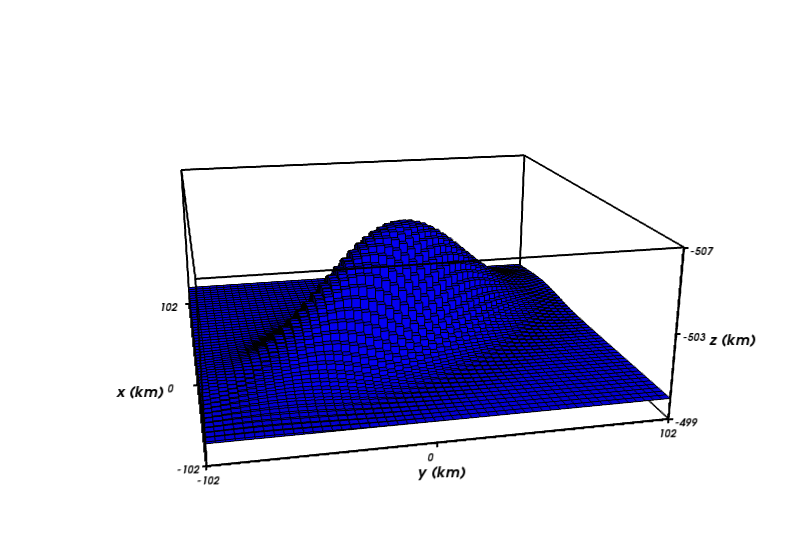

In [6]:
bounds = [area[0]-auxx, area[1]+auxx,
          area[2]-auxy, area[3]+auxy,
          z0-7000,z0+1000] # Limites da região de visualização 3D
escala = (1,1,10)

scene = myv.figure(size=(800,600))
myv.prisms(TT, prop='density', opacity = 1, scale=escala)
ax = myv.axes(myv.outline(bounds, scale=escala), ranges=[b*0.001 for b in bounds], nlabels=3, fmt='%.0f', )
ax.axes.x_label, ax.axes.y_label, ax.axes.z_label = 'x (km)', 'y (km)', 'z (km)'
ax.axes.font_factor = 1.0
scene.scene.camera.position = [-488377.82089107845, -109890.22530098612, -5193065.2309212582]
scene.scene.camera.focal_point = [2000.0000000015173, 2000.0000000008251, -5029999.9999999655]
scene.scene.camera.view_angle = 30.0
scene.scene.camera.view_up = [0.30138086810157283, 0.065473475009889232, -0.95125327668947979]
scene.scene.camera.clipping_range = [267716.39247072284, 858620.47047816461]
scene.scene.camera.compute_view_plane_normal()
scene.scene.render()
myv.savefig('TT.png')
myv.show()
Image(filename='TT.png')

### Construção do modelo com a topografia

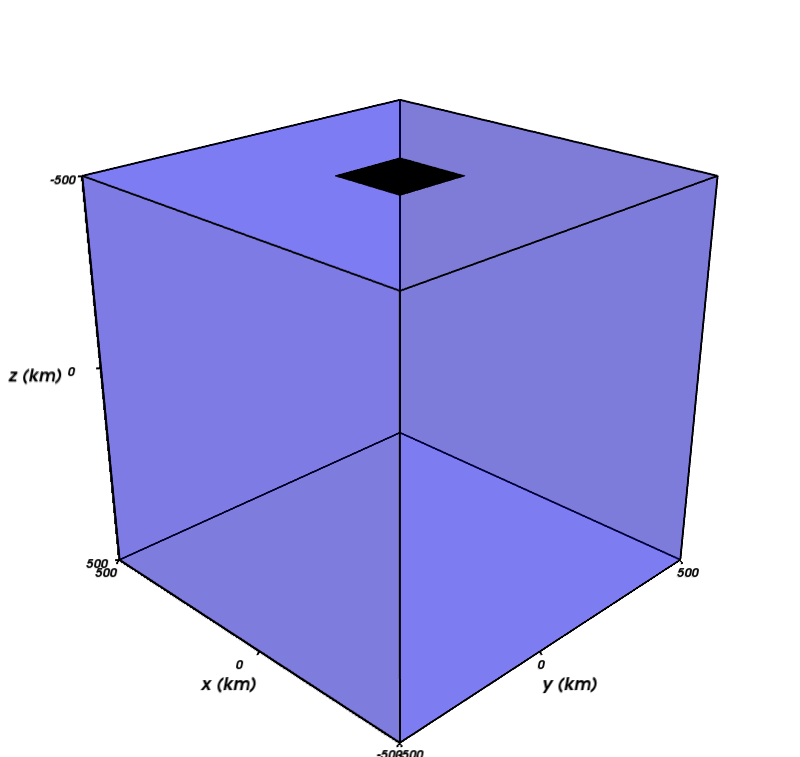

In [7]:
#modelo 3D
CT = list(CN)

for i, t in enumerate(TT):
    CT.append(t)

#modelo 2D
CT2D = list(CN2D)

for i, t in enumerate(TT2D):
    CT2D.append(t)

bounds = [-0.5*L, 0.5*L, -0.5*L, 0.5*L, -0.5*L, 0.5*L] # Limites da região de visualização 3D

myv.figure(size=(800,800))
myv.prisms([CT[0]], prop='density', opacity = 0.3)
#for i, t in enumerate(CT,1):
#    myv.prisms([t], prop='density', opacity = 1)
myv.prisms(TT, prop='density', opacity = 1)
ax = myv.axes(myv.outline(bounds), ranges=[b*0.001 for b in bounds], nlabels=3, fmt='%.0f')
ax.axes.x_label, ax.axes.y_label, ax.axes.z_label = 'x (km)', 'y (km)', 'z (km)'
ax.axes.font_factor = 1.0
myv.savefig('CT.png')
myv.show()
Image(filename='CT.png')

### A figura acima mostra o modelo CT. Este modelo é composto pelo CN (azul transparente) e uma topografia na superfície (prismas azuis sólidos). Esta topografia sintética possui a mesma densidade de CN.

### Cálculo da componente $z$ (vertical) da aceleração gravitacional

In [8]:
#Modelo CN
gn = prism.gz(xp, yp, zp, CN)
gn_sup = prism.gz(xp, yp, zp_sup, CN)

#Modelo CT
gt = prism.gz(xp, yp, zp, CT)
gt_sup = prism.gz(xp, yp, zp_sup, CT)

### Cálculo do distúrbio gravitacional

In [9]:
dt = gt - gn
dt_sup = gt_sup - gn_sup

### Componente $z$ (vertical) da aceleração gravitacional $g_{t}$ e distúrbio gravitacional $d_{t}$ (calculados em uma superfície plana)

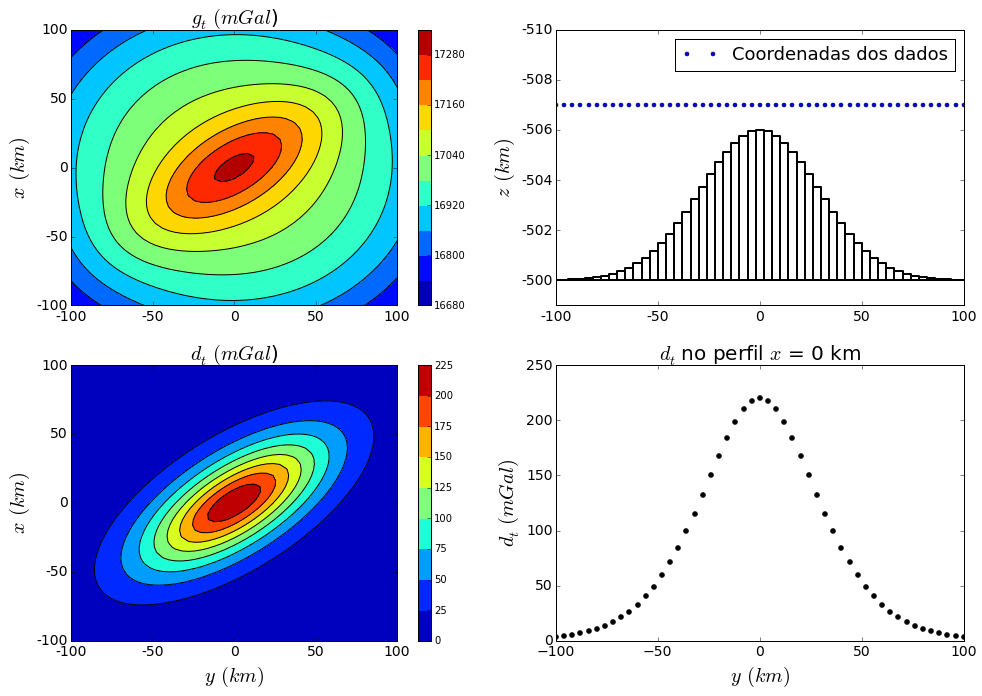

In [10]:
mpl.close('all')
mpl.figure(figsize=(14,10))

mpl.subplot(2,2,1)
mpl.title('$g_{t} \, (mGal$)', fontsize=20)
nlevels = mpl.contourf(yp, xp, gt, shape, 10)
mpl.colorbar()
mpl.contour(yp, xp, gt, shape, nlevels, color='k', 
            linewidth=1, clabel=False)
mpl.ylim(area[0], area[1])
mpl.xlim(area[2], area[3])
mpl.ylabel('$x \, (km)$', fontsize=20)
mpl.xticks(fontsize=14)
mpl.yticks(fontsize=14)
mpl.m2km()

mpl.subplot(2,2,2)
for i, p in enumerate(CT2D):
    mpl.polygon(p, style='-k', linewidth=2)
mpl.plot(yp[perfil], zp[perfil], 'bo', markersize=4,
         label='Coordenadas dos dados')
mpl.xlim(-lambida, lambida)
mpl.ylim(z0+1000, z0-10000)
mpl.ylabel('$z \, (km)$', fontsize=20)
mpl.xticks(fontsize=14)
mpl.yticks(fontsize=14)
mpl.legend(loc='best', fontsize=18)
mpl.m2km()

mpl.subplot(2,2,3)
mpl.title('$d_{t} \, (mGal$)', fontsize=20)
nlevels = mpl.contourf(yp, xp, dt, shape, 10)
mpl.colorbar()
mpl.contour(yp, xp, dt, shape, nlevels, color='k', 
            linewidth=1, clabel=False)
mpl.ylim(area[0], area[1])
mpl.xlim(area[2], area[3])
mpl.xlabel('$y \, (km)$', fontsize=20)
mpl.ylabel('$x \, (km)$', fontsize=20)
mpl.xticks(fontsize=14, )
mpl.yticks(fontsize=14)
mpl.m2km()

mpl.subplot(2,2,4)
mpl.title('$d_{t}$ no perfil $x$ = 0 km', fontsize=20)
mpl.plot(0.001*yp[perfil], dt[perfil], 'ko', markersize=5)
mpl.paths([[0.001*area[2], 0.0]], [[0.001*area[3], 0.0]], 'k--')
mpl.xlim(0.001*area[2], 0.001*area[3])
mpl.xlabel('$y \, (km)$', fontsize=20)
mpl.ylabel('$d_{t} \, (mGal)$', fontsize=20)
mpl.xticks(fontsize=14)
mpl.yticks(fontsize=14)

mpl.tight_layout(pad=2)

### Componente $z$ (vertical) da aceleração gravitacional $g_{t}$ e distúrbio gravitacional $d_{t}$ (sobre a topografia)

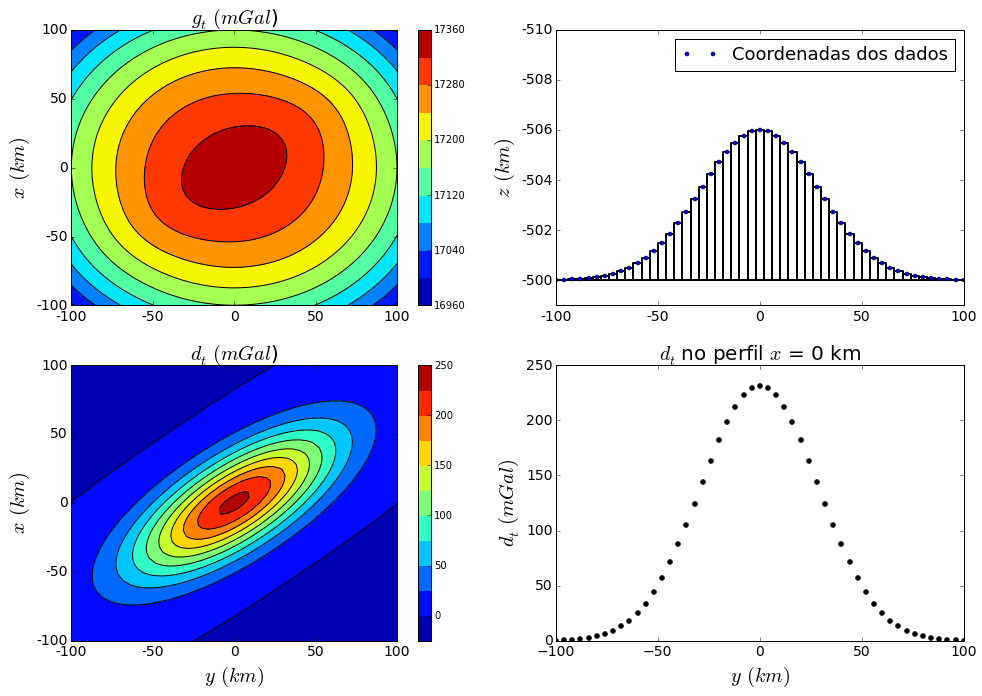

In [11]:
mpl.close('all')
mpl.figure(figsize=(14,10))

mpl.subplot(2,2,1)
mpl.title('$g_{t} \, (mGal$)', fontsize=20)
nlevels = mpl.contourf(yp, xp, gt_sup, shape, 10)
mpl.colorbar()
mpl.contour(yp, xp, gt_sup, shape, nlevels, color='k', 
            linewidth=1, clabel=False)
mpl.ylim(area[0], area[1])
mpl.xlim(area[2], area[3])
mpl.ylabel('$x \, (km)$', fontsize=20)
mpl.xticks(fontsize=14)
mpl.yticks(fontsize=14)
mpl.m2km()

mpl.subplot(2,2,2)
for i, p in enumerate(CT2D):
    mpl.polygon(p, style='-k', linewidth=2)
mpl.plot(yp[perfil], zp_sup[perfil], 'bo', markersize=4,
         label='Coordenadas dos dados')
mpl.xlim(-lambida, lambida)
mpl.ylim(z0+1000, z0-10000)
mpl.ylabel('$z \, (km)$', fontsize=20)
mpl.xticks(fontsize=14)
mpl.yticks(fontsize=14)
mpl.legend(loc='best', fontsize=18)
mpl.m2km()

mpl.subplot(2,2,3)
mpl.title('$d_{t} \, (mGal$)', fontsize=20)
nlevels = mpl.contourf(yp, xp, dt_sup, shape, 10)
mpl.colorbar()
mpl.contour(yp, xp, dt_sup, shape, nlevels, color='k', 
            linewidth=1, clabel=False)
mpl.ylim(area[0], area[1])
mpl.xlim(area[2], area[3])
mpl.xlabel('$y \, (km)$', fontsize=20)
mpl.ylabel('$x \, (km)$', fontsize=20)
mpl.xticks(fontsize=14, )
mpl.yticks(fontsize=14)
mpl.m2km()

mpl.subplot(2,2,4)
mpl.title('$d_{t}$ no perfil $x$ = 0 km', fontsize=20)
mpl.plot(0.001*yp[perfil], dt_sup[perfil], 'ko', markersize=5)
mpl.paths([[0.001*area[2], 0.0]], [[0.001*area[3], 0.0]], 'k--')
mpl.xlim(0.001*area[2], 0.001*area[3])
mpl.xlabel('$y \, (km)$', fontsize=20)
mpl.ylabel('$d_{t} \, (mGal)$', fontsize=20)
mpl.xticks(fontsize=14)
mpl.yticks(fontsize=14)

mpl.tight_layout(pad=2)

## Efeito das massas topográficas

### Remoção da componente $z$ (vertical) da aceleração gravitacional exercida pela topografia do modelo CT. A topografia do modelo CT é representada pela massa anômala localizada na parte superior.

In [12]:
tt = prism.gz(xp, yp, zp, TT)
tt_sup = prism.gz(xp, yp, zp_sup, TT)

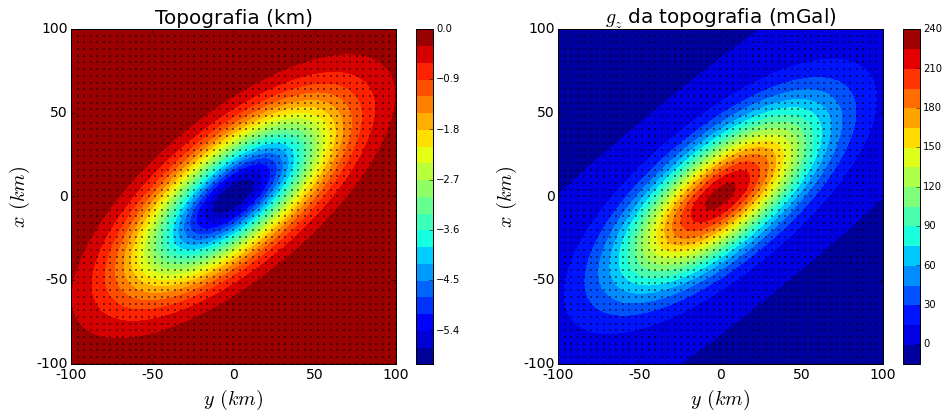

In [13]:
mpl.close('all')
mpl.figure(figsize=(16,6))
mpl.subplot(1, 2, 1)
mpl.title('Topografia (km)', fontsize=20)
mpl.contourf(yp, xp, 0.001*topo, shape, 20)
mpl.colorbar()
mpl.plot(yp, xp, 'ko', markersize=1)
mpl.ylabel('$x \, (km)$', fontsize=20)
mpl.xlabel('$y \, (km)$', fontsize=20)
mpl.yticks(fontsize=14)
mpl.xticks(fontsize=14)
mpl.m2km()
mpl.subplot(1, 2, 2)
mpl.title('$g_{z}$ da topografia (mGal)', fontsize=20)
mpl.contourf(yp, xp, tt_sup, shape, 20)
mpl.colorbar()
mpl.plot(yp, xp, 'ko', markersize=1)
mpl.ylabel('$x \, (km)$', fontsize=20)
mpl.xlabel('$y \, (km)$', fontsize=20)
mpl.yticks(fontsize=14)
mpl.xticks(fontsize=14)
mpl.m2km()
mpl.show()

### Distúrbio gravitacional corrigido do efeito da topografia $d_{t}^{corr}$

In [14]:
dtcorr = dt - tt
dtcorr_sup = dt_sup - tt_sup

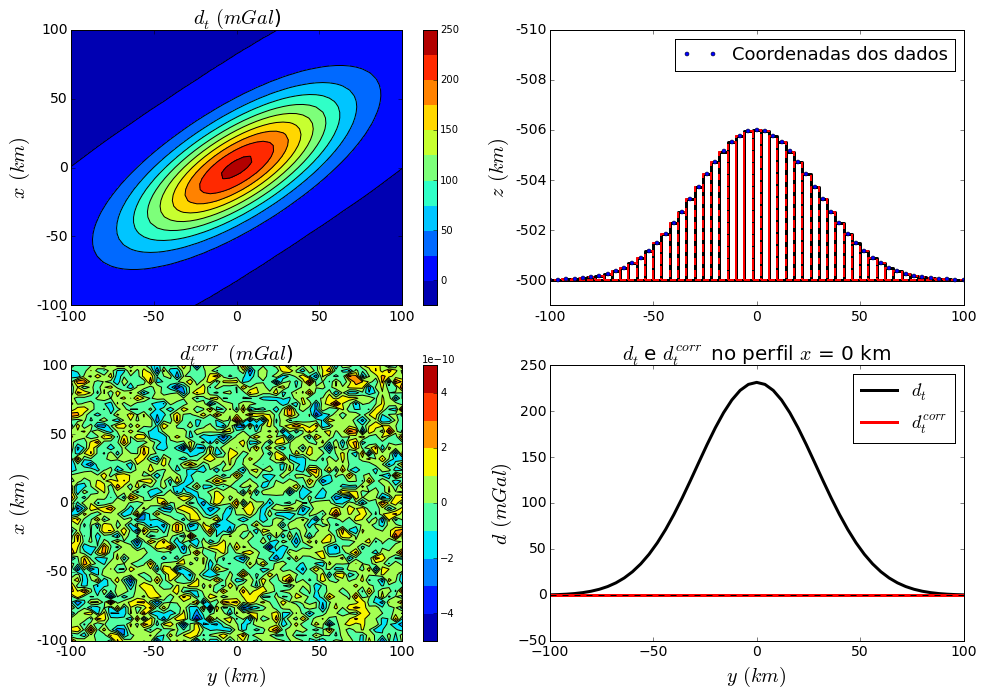

In [15]:
mpl.close('all')
mpl.figure(figsize=(14,10))

mpl.subplot(2,2,1)
mpl.title('$d_{t} \, (mGal$)', fontsize=20)
nlevels = mpl.contourf(yp, xp, dt_sup, shape, 10)
mpl.colorbar()
mpl.contour(yp, xp, dt_sup, shape, nlevels, color='k', 
            linewidth=1, clabel=False)
mpl.ylim(area[0], area[1])
mpl.xlim(area[2], area[3])
mpl.ylabel('$x \, (km)$', fontsize=20)
mpl.xticks(fontsize=14, )
mpl.yticks(fontsize=14)
mpl.m2km()

mpl.subplot(2,2,2)
for i, p in enumerate(CT2D):
    mpl.polygon(p, style='-k', linewidth=3)
for i, p in enumerate(TT2D):
    mpl.polygon(p, style='--r', linewidth=2)
mpl.plot(yp[perfil], zp_sup[perfil], 'bo', markersize=4, 
         label='Coordenadas dos dados')
mpl.xlim(area[2], area[3])
mpl.ylim(z0+1000, z0-10000)
mpl.ylabel('$z \, (km)$', fontsize=20)
mpl.xticks(fontsize=14)
mpl.yticks(fontsize=14)
mpl.legend(loc='best', fontsize=18)
mpl.m2km()

mpl.subplot(2,2,3)
mpl.title('$d_{t}^{corr} \, (mGal$)', fontsize=20)
nlevels = mpl.contourf(yp, xp, dtcorr_sup, shape, 10)
mpl.colorbar()
mpl.contour(yp, xp, dtcorr_sup, shape, nlevels, color='k', 
            linewidth=1, clabel=False)
mpl.ylim(area[0], area[1])
mpl.xlim(area[2], area[3])
mpl.xlabel('$y \, (km)$', fontsize=20)
mpl.ylabel('$x \, (km)$', fontsize=20)
mpl.xticks(fontsize=14, )
mpl.yticks(fontsize=14)
mpl.m2km()

mpl.subplot(2,2,4)
mpl.title('$d_{t}$ e $d_{t}^{corr}$ no perfil $x$ = 0 km', fontsize=20)
mpl.plot(0.001*yp[perfil], dt_sup[perfil], 'k-', 
         linewidth=3, label='$d_{t}$')
mpl.plot(0.001*yp[perfil], dtcorr_sup[perfil], 'r-', 
         linewidth=3, label='$d_{t}^{corr}$')
mpl.paths([[0.001*area[2], 0.0]], [[0.001*area[3], 0.0]], 'k--')
mpl.xlim(0.001*area[2], 0.001*area[3])
mpl.xlabel('$y \, (km)$', fontsize=20)
mpl.ylabel('$d \, (mGal)$', fontsize=20)
mpl.xticks(fontsize=14)
mpl.yticks(fontsize=14)
mpl.legend(loc='best', fontsize=18, numpoints=1)

mpl.tight_layout(pad=2)

### Observe que a remoção do efeito da topografia no modelo CT praticamente reduz o distúrbio gravitacional a zero

## Aproximação para o efeito da topografia (placa de Bouguer)

### A atração gravitacional exercida no ponto $P$ por uma placa com densidade $\rho$, espessura $H$ e que é infinida horizontalmente $\left( L \gg H \right)$ é dada por $2 \pi G \rho H$, em que $G$ é a constante gravitacional.

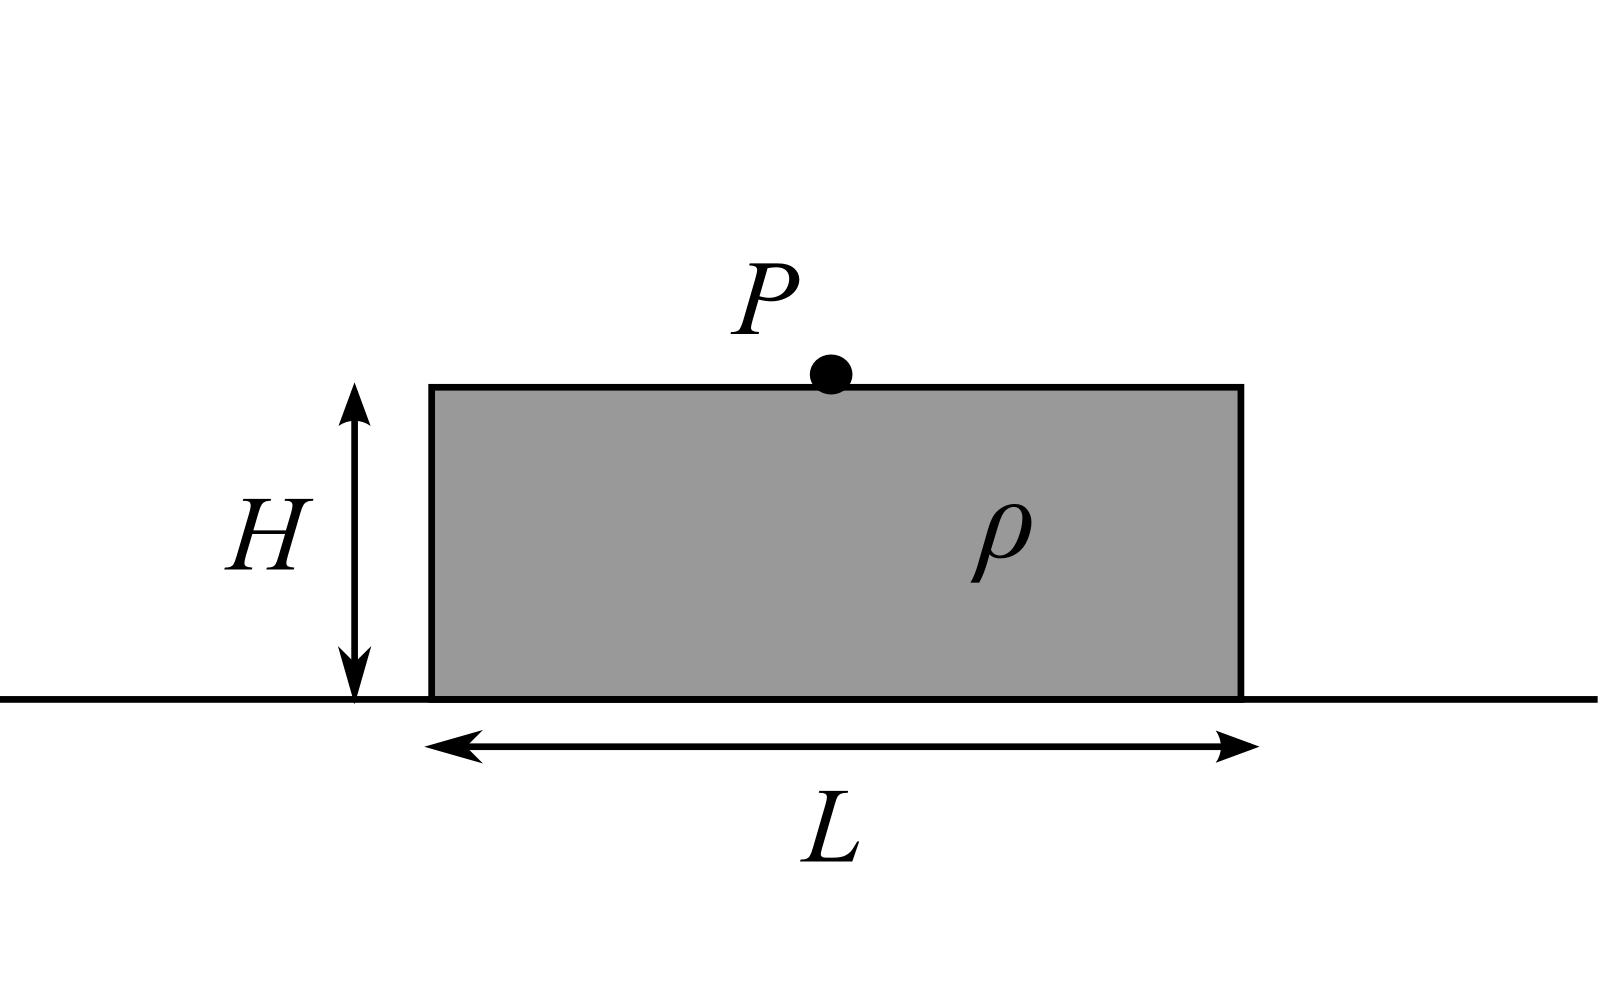

In [16]:
Image(filename='placa_bouguer.png')

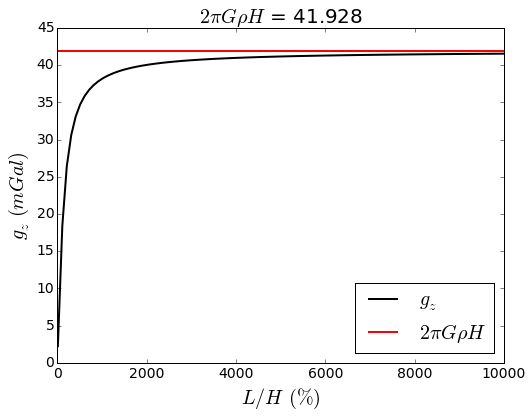

In [17]:
H = 1000.0
rho = 1000.0
lado_prisma_bouguer = np.linspace(0.1*H, 100*H, 101)
gz_placa_bouguer = 2*np.pi*G*H*rho*SI2MGAL
gz_prisma_bouguer = []
for i, l in enumerate(lado_prisma_bouguer):
    prisma_bouguer = [mesher.Prism(-0.5*l,0.5*l,-0.5*l,0.5*l,-H,0, props={'density':rho})]
    aux = prism.gz(np.array([0.0]), np.array([0.0]),
                   np.array([-(H+1.0)]), prisma_bouguer)
    gz_prisma_bouguer.append(aux)
    
mpl.close('all')
mpl.figure(figsize=(8,6))
mpl.title('$2 \pi G \\rho H$ = %.3f' % gz_placa_bouguer, fontsize=20)
mpl.plot((100.0/H)*lado_prisma_bouguer, gz_prisma_bouguer, 
         'k-', linewidth=2, label='$g_{z}$')
mpl.paths([[(100.0/H)*lado_prisma_bouguer[0], gz_placa_bouguer]],
          [[(100.0/H)*lado_prisma_bouguer[-1], gz_placa_bouguer]], 
          'r-', linewidth=2, label='$2 \pi G \\rho H$')
mpl.ylabel('$g_{z} \, (mGal)$', fontsize=20)
mpl.xlabel('$L/H \, (\%)$', fontsize=20)
mpl.yticks(fontsize=14)
mpl.xticks(fontsize=14)
mpl.legend(loc='lower right', fontsize=20)
mpl.show()

### Na figura acima, é feita uma comparação entre a atração gravitacional exercida em um ponto $P$ localizado no topo de uma placa infinita horizontalmente $\left( L \gg H\right)$ com o valor de $g_{z}$ produzido por diferentes prismas com diferentes dimensões horizontais $L$. Observa-se que, à medida que $L$ aumenta, a componente vertical $g_{z}$ (linha preta) tende ao valor da atração gravitacional (linha vermelha) exercida por um placa infinita horizontalmente.

### Cálculo do efeito gravitacional da topografia via placa de Bouguer utilizando o valor verdadeiro $\rho_{t}$ para a densidade da topografia.

In [18]:
bouguer = utils.si2mgal(2.0*np.pi*G*rhon*np.abs(topo))

#bouguer = utils.si2mgal(2.0*np.pi*G*rhon*0.95*np.abs(topo))

#bouguer = utils.si2mgal(2.0*np.pi*G*rhon*0.9*np.abs(topo))

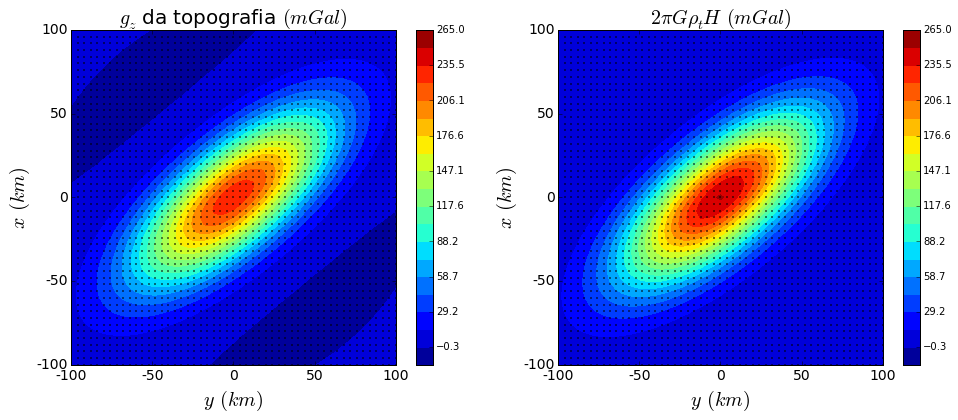

In [19]:
nlevels = np.linspace(-15,265,20)
mpl.close('all')
mpl.figure(figsize=(16,6))
mpl.subplot(1, 2, 1)
mpl.title('$g_{z}$ da topografia $(mGal)$', fontsize=20)
mpl.contourf(yp, xp, tt_sup, shape, nlevels)
mpl.colorbar()
mpl.plot(yp, xp, 'ko', markersize=1)
mpl.ylabel('$x \, (km)$', fontsize=20)
mpl.xlabel('$y \, (km)$', fontsize=20)
mpl.yticks(fontsize=14)
mpl.xticks(fontsize=14)
mpl.m2km()
mpl.subplot(1, 2, 2)
mpl.title('$2 \pi G \\rho_{t} H \, (mGal)$', fontsize=20)
mpl.contourf(yp, xp, bouguer, shape, nlevels)
mpl.colorbar()
mpl.plot(yp, xp, 'ko', markersize=1)
mpl.ylabel('$x \, (km)$', fontsize=20)
mpl.xlabel('$y \, (km)$', fontsize=20)
mpl.yticks(fontsize=14)
mpl.xticks(fontsize=14)
mpl.m2km()
mpl.show()

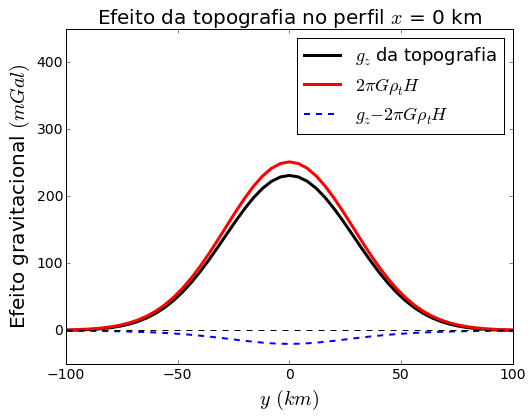

In [20]:
mpl.close('all')
mpl.figure(figsize=(8,6))
mpl.title('Efeito da topografia no perfil $x$ = 0 km', fontsize=20)
mpl.plot(0.001*yp[perfil], tt_sup[perfil], 'k-', 
         linewidth=3, label='$g_{z}$ da topografia')
mpl.plot(0.001*yp[perfil], bouguer[perfil], 'r-', 
         linewidth=3, label='$2 \pi G \\rho_{t} H$')
mpl.plot(0.001*yp[perfil], tt_sup[perfil]-bouguer[perfil], 'b--', 
         linewidth=2, label='$g_{z} - 2 \pi G \\rho_{t} H$')
mpl.paths([[0.001*area[2], 0.0]], [[0.001*area[3], 0.0]], 'k--')
mpl.xlim(0.001*area[2], 0.001*area[3])
mpl.xlabel('$y \, (km)$', fontsize=20)
mpl.ylabel('Efeito gravitacional $(mGal)$', fontsize=20)
mpl.xticks(fontsize=14)
mpl.yticks(fontsize=14)
mpl.ylim(-50, 450)
mpl.legend(loc='upper right', fontsize=18, numpoints=1)
mpl.show()

### Distúrbio gravitacional corrigido do efeito da topografia calculado via correção de Bouguer $\left(2 \pi G \rho_{t} H \right)$ utilizando o valor verdadeiro $\rho_{t}$ para a densidade da topografia.

In [21]:
dtcorr_bouguer = dt - bouguer
dtcorr_bouguer_sup = dt_sup - bouguer

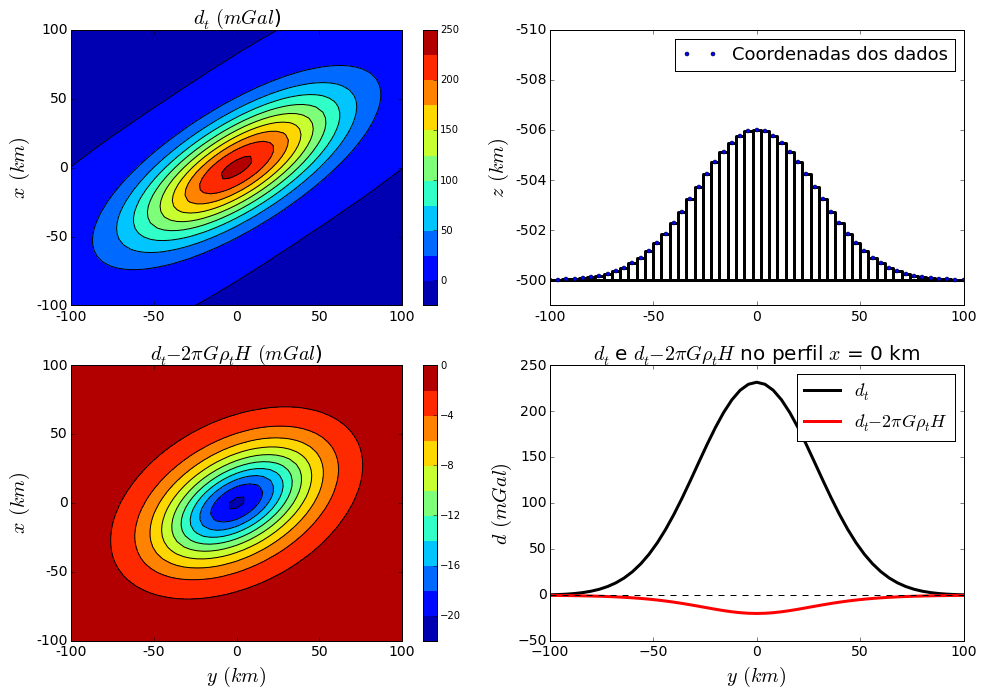

In [22]:
mpl.close('all')
mpl.figure(figsize=(14,10))

mpl.subplot(2,2,1)
mpl.title('$d_{t} \, (mGal$)', fontsize=20)
nlevels = mpl.contourf(yp, xp, dt_sup, shape, 10)
mpl.colorbar()
mpl.contour(yp, xp, dt_sup, shape, nlevels, color='k', 
            linewidth=1, clabel=False)
mpl.ylim(area[0], area[1])
mpl.xlim(area[2], area[3])
mpl.ylabel('$x \, (km)$', fontsize=20)
mpl.xticks(fontsize=14, )
mpl.yticks(fontsize=14)
mpl.m2km()

mpl.subplot(2,2,2)
for i, p in enumerate(CT2D):
    mpl.polygon(p, style='-k', linewidth=3)
mpl.plot(yp[perfil], zp_sup[perfil], 'bo', markersize=4, 
         label='Coordenadas dos dados')
mpl.xlim(area[2], area[3])
mpl.ylim(z0+1000, z0-10000)
mpl.ylabel('$z \, (km)$', fontsize=20)
mpl.xticks(fontsize=14)
mpl.yticks(fontsize=14)
mpl.legend(loc='best', fontsize=18)
mpl.m2km()

mpl.subplot(2,2,3)
mpl.title('$d_{t} - 2 \pi G \\rho_{t} H \, (mGal$)', fontsize=20)
nlevels = mpl.contourf(yp, xp, dtcorr_bouguer_sup, shape, 10)
mpl.colorbar()
mpl.contour(yp, xp, dtcorr_bouguer_sup, shape, nlevels, color='k', 
            linewidth=1, clabel=False)
mpl.ylim(area[0], area[1])
mpl.xlim(area[2], area[3])
mpl.xlabel('$y \, (km)$', fontsize=20)
mpl.ylabel('$x \, (km)$', fontsize=20)
mpl.xticks(fontsize=14, )
mpl.yticks(fontsize=14)
mpl.m2km()

mpl.subplot(2,2,4)
mpl.title('$d_{t}$ e $d_{t} - 2 \pi G \\rho_{t} H$ no perfil $x$ = 0 km', fontsize=20)
mpl.plot(0.001*yp[perfil], dt_sup[perfil], 'k-', 
         linewidth=3, label='$d_{t}$')
mpl.plot(0.001*yp[perfil], dtcorr_bouguer_sup[perfil], 'r-', 
         linewidth=3, label='$d_{t} - 2 \pi G \\rho_{t} H$')
mpl.paths([[0.001*area[2], 0.0]], [[0.001*area[3], 0.0]], 'k--')
mpl.xlim(0.001*area[2], 0.001*area[3])
mpl.xlabel('$y \, (km)$', fontsize=20)
mpl.ylabel('$d \, (mGal)$', fontsize=20)
mpl.xticks(fontsize=14)
mpl.yticks(fontsize=14)
mpl.legend(loc='best', fontsize=18, numpoints=1)

mpl.tight_layout(pad=2)

### Comparação entre o distúrbio corrigido do efeito gravitacional da topografia e o distúrbio corrigido pela placa de Bouguer que utiliza o valor verdadeiro $\rho_{t}$ para a densidade da topografia.

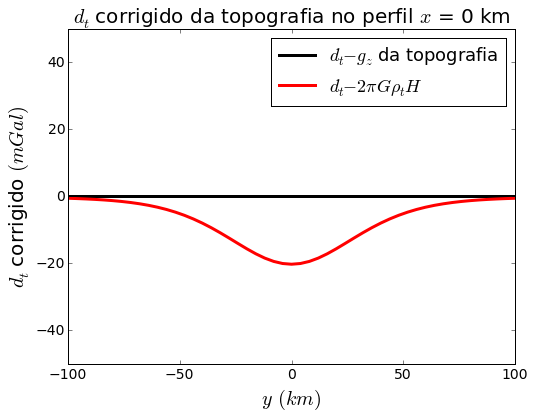

In [23]:
mpl.close('all')
mpl.figure(figsize=(8,6))
mpl.title('$d_{t}$ corrigido da topografia no perfil $x$ = 0 km', fontsize=20)
mpl.plot(0.001*yp[perfil], dtcorr_sup[perfil], 'k-', 
         linewidth=3, label='$d_{t} - g_{z}$ da topografia')
mpl.plot(0.001*yp[perfil], dtcorr_bouguer_sup[perfil], 'r-', 
         linewidth=3, label='$d_{t} - 2 \pi G \\rho_{t} H$')
mpl.paths([[0.001*area[2], 0.0]], [[0.001*area[3], 0.0]], 'k--')
mpl.xlim(0.001*area[2], 0.001*area[3])
mpl.xlabel('$y \, (km)$', fontsize=20)
mpl.ylabel('$d_{t}$ corrigido $(mGal)$', fontsize=20)
mpl.xticks(fontsize=14)
mpl.yticks(fontsize=14)
mpl.ylim(-50, 50)
mpl.legend(loc='upper right', fontsize=18, numpoints=1)
mpl.show()

### Estimativa da *densidade ótima* $\hat{\rho}$ para a topografia. Esta densidade $\hat{\rho}$ resulta na covariância mínima entre o dado corrigido via placa de Bouger e a topografia.

$\hat{\rho} = \dfrac{\text{cov}(g, H)}{2 \pi G \, \text{cov}(H, H)}$

In [24]:
media_dt_sup = np.mean(dt_sup)
media_topo = -np.mean(topo)
cov_dt_sup_topo = np.sum((dt_sup - media_dt_sup)*(-topo - media_topo))/(len(topo)-1)
cov_topo_topo = np.sum((-topo - media_topo)*(-topo - media_topo))/(len(topo)-1)

rho_estimado = cov_dt_sup_topo/(2*np.pi*G*SI2MGAL*cov_topo_topo)
'rho_estimado/rhot = %.3f' % (rho_estimado/rhot)

'rho_estimado/rhot = 0.929'

### Observe que o valor estimado (acima) é menor que o verdadeiro.

In [25]:
bouguer_estimado = utils.si2mgal(2.0*np.pi*G*rho_estimado*np.abs(topo))

In [26]:
dtcorr_bouguer_sup_est = dt_sup - bouguer_estimado

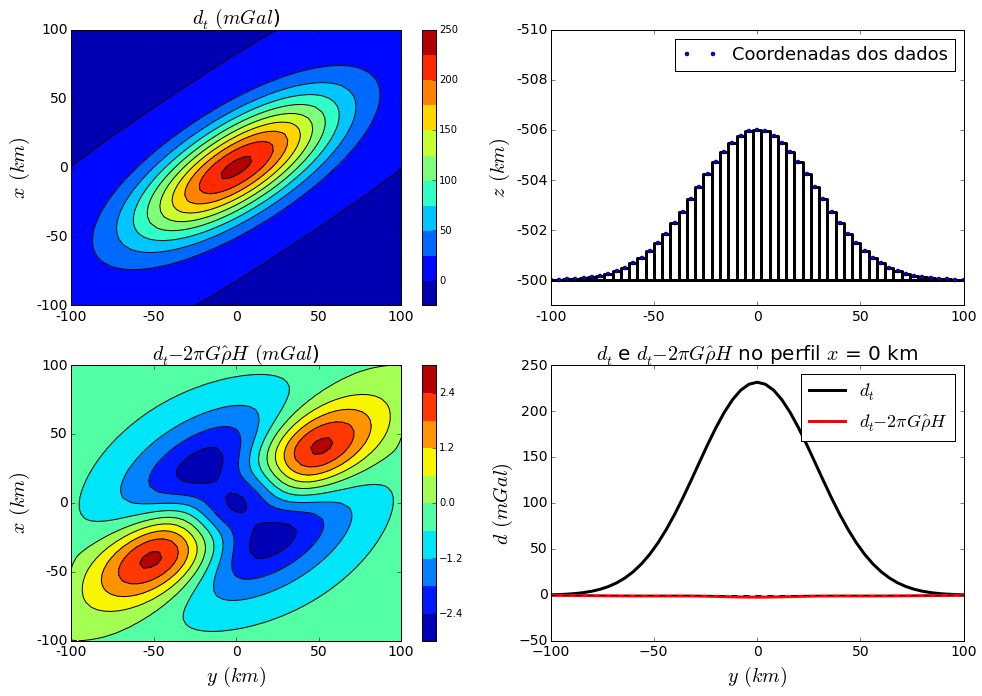

In [27]:
mpl.close('all')
mpl.figure(figsize=(14,10))

mpl.subplot(2,2,1)
mpl.title('$d_{t} \, (mGal$)', fontsize=20)
nlevels = mpl.contourf(yp, xp, dt_sup, shape, 10)
mpl.colorbar()
mpl.contour(yp, xp, dt_sup, shape, nlevels, color='k', 
            linewidth=1, clabel=False)
mpl.ylim(area[0], area[1])
mpl.xlim(area[2], area[3])
mpl.ylabel('$x \, (km)$', fontsize=20)
mpl.xticks(fontsize=14, )
mpl.yticks(fontsize=14)
mpl.m2km()

mpl.subplot(2,2,2)
for i, p in enumerate(CT2D):
    mpl.polygon(p, style='-k', linewidth=3)
mpl.plot(yp[perfil], zp_sup[perfil], 'bo', markersize=4, 
         label='Coordenadas dos dados')
mpl.xlim(area[2], area[3])
mpl.ylim(z0+1000, z0-10000)
mpl.ylabel('$z \, (km)$', fontsize=20)
mpl.xticks(fontsize=14)
mpl.yticks(fontsize=14)
mpl.legend(loc='best', fontsize=18)
mpl.m2km()

mpl.subplot(2,2,3)
mpl.title('$d_{t} - 2 \pi G \hat{\\rho} H \, (mGal$)', fontsize=20)
nlevels = mpl.contourf(yp, xp, dtcorr_bouguer_sup_est, shape, 10)
mpl.colorbar()
mpl.contour(yp, xp, dtcorr_bouguer_sup_est, shape, nlevels, color='k', 
            linewidth=1, clabel=False)
mpl.ylim(area[0], area[1])
mpl.xlim(area[2], area[3])
mpl.xlabel('$y \, (km)$', fontsize=20)
mpl.ylabel('$x \, (km)$', fontsize=20)
mpl.xticks(fontsize=14, )
mpl.yticks(fontsize=14)
mpl.m2km()

mpl.subplot(2,2,4)
mpl.title('$d_{t}$ e $d_{t} - 2 \pi G \hat{\\rho} H$ no perfil $x$ = 0 km', fontsize=20)
mpl.plot(0.001*yp[perfil], dt_sup[perfil], 'k-', 
         linewidth=3, label='$d_{t}$')
mpl.plot(0.001*yp[perfil], dtcorr_bouguer_sup_est[perfil], 'r-', 
         linewidth=3, label='$d_{t} - 2 \pi G \hat{\\rho} H$')
mpl.paths([[0.001*area[2], 0.0]], [[0.001*area[3], 0.0]], 'k--')
mpl.xlim(0.001*area[2], 0.001*area[3])
mpl.xlabel('$y \, (km)$', fontsize=20)
mpl.ylabel('$d \, (mGal)$', fontsize=20)
mpl.xticks(fontsize=14)
mpl.yticks(fontsize=14)
mpl.legend(loc='best', fontsize=18, numpoints=1)

mpl.tight_layout(pad=2)

### Comparação entre o distúrbio corrigido do efeito gravitacional da topografia e o distúrbio corrigido pela placa de Bouguer com o valor verdadeiro $\rho_{t}$ e com o valor estimado $\hat{\rho}$ para a densidade da topografia.

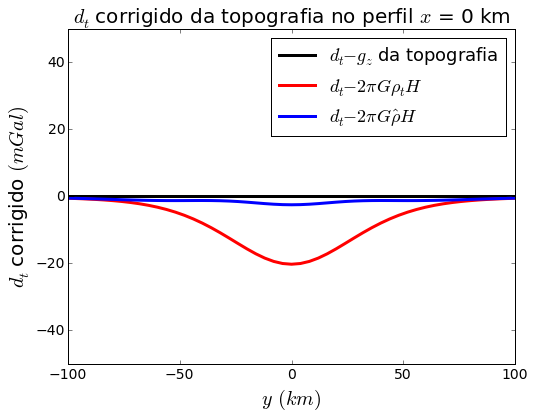

In [28]:
mpl.close('all')
mpl.figure(figsize=(8,6))
mpl.title('$d_{t}$ corrigido da topografia no perfil $x$ = 0 km', fontsize=20)
mpl.plot(0.001*yp[perfil], dtcorr_sup[perfil], 'k-', 
         linewidth=3, label='$d_{t} - g_{z}$ da topografia')
mpl.plot(0.001*yp[perfil], dtcorr_bouguer_sup[perfil], 'r-', 
         linewidth=3, label='$d_{t} - 2 \pi G \\rho_{t} H$')
mpl.plot(0.001*yp[perfil], dtcorr_bouguer_sup_est[perfil], 'b-', 
         linewidth=3, label='$d_{t} - 2 \pi G \hat{\\rho} H$')
mpl.paths([[0.001*area[2], 0.0]], [[0.001*area[3], 0.0]], 'k--')
mpl.xlim(0.001*area[2], 0.001*area[3])
mpl.xlabel('$y \, (km)$', fontsize=20)
mpl.ylabel('$d_{t}$ corrigido $(mGal)$', fontsize=20)
mpl.xticks(fontsize=14)
mpl.yticks(fontsize=14)
mpl.ylim(-50, 50)
mpl.legend(loc='upper right', fontsize=18, numpoints=1)
mpl.show()